# Header

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json
#import spinmob as s
#import camb
#import time
#%matplotlib notebook

# Import LIGO stuff
import readligo as rl

In [7]:
# check directory
os.chdir("D:\Raphael\Dropbox\Mcgill\JupyterNotebook\PHYS512\LIGO_Assignment5")
os.getcwd()

'D:\\Raphael\\Dropbox\\Mcgill\\JupyterNotebook\\PHYS512\\LIGO_Assignment5'

# Functions

In [8]:
# Gaussian fonction
def Gaus(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

Key will be getting LIGO data from:

https://www.gw-openscience.org/static/events/LOSC_Event_tutorial.zip

While they include code to do much of this, please don’t use it (although
you may look at it for inspiration) and instead write your own. You can
look at/use simple read ligo.py that I have posted for concise code to read
the hdf5 files. Feel free to have your code loop over the events and print the
answer to each part for that event. In order to make our life easy, in case
we have to re-run your code (which we should not have to do), please also
have a variable at the top of your code that sets the directory where you
have unzipped the data.
# Question 1
Find gravitational waves! Parts should include
## a)
Come up with a noise model for Livingston and Hanford separately.
Describe in comments how you go about doing this. Please mention something about how you smooth the power spectrum and how you deal with
lines (if at all). Please also explain how you window the data (you may want
to use a window that has an extended flat period near the center to avoid
tapering the data/template where the signal is not small).

In [22]:
# First let's load the an even:

#Select an event:
eventname = 'GW150914'
#eventname = 'GW151226' 
#eventname = 'LVT151012'
#eventname = 'GW170104'

#Load the event
json_name = "BBH_events_v3.json"
events = json.load(open(json_name,"r"))

# Extract the event's parameters:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data (.hdf5 file)
fn_L1 = event['fn_L1']              # File name for L1 data (.hdf5 file)
fn_template = event['fn_template']  # File name for template waveform (.hdf5 file)
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
utcevent = event['utcevent']        # Date of event
m1 = event['m1']
m2 = event['m2']
a1 = event['a1']
a2 = event['a2']
approx = event['approx']
fband = event['fband']              # frequency band for bandpassing signal
f_min = event['f_min']
events[eventname]

{'name': 'GW150914',
 'fn_H1': 'H-H1_LOSC_4_V2-1126259446-32.hdf5',
 'fn_L1': 'L-L1_LOSC_4_V2-1126259446-32.hdf5',
 'fn_template': 'GW150914_4_template.hdf5',
 'fs': 4096,
 'tevent': 1126259462.44,
 'utcevent': '2015-09-14T09:50:45.44',
 'm1': 41.743,
 'm2': 29.237,
 'a1': 0.355,
 'a2': -0.769,
 'approx': 'lalsim.SEOBNRv2',
 'fband': [43.0, 300.0],
 'f_min': 10.0}

In [27]:
# Now, let's load the data for our selected event
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
print("Data of event {} loaded".format(eventname))

Data of event GW150914 loaded


Text(0.5, 1.0, 'Advanced LIGO strain data near GW150914')

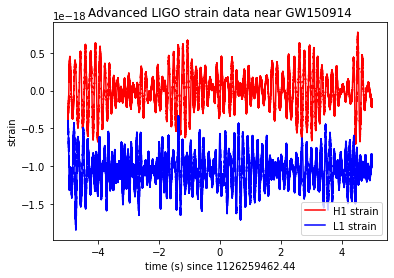

In [30]:
# Time vector of Livingston and Hanford are identical
time = time_H1
# define timestep
dt = time[1]-time[0]

# Define a region around the event (+/- t_interv around event.)
t_interv = 5
indxt = np.where((time >= tevent-t_interv) & (time < tevent+t_interv))

#Plot data around event. 
plt.figure()
plt.plot(time[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
plt.plot(time[indxt]-tevent,strain_L1[indxt],'b',label='L1 strain')
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('strain')
plt.legend()
plt.title('Advanced LIGO strain data near '+eventname)

In [ ]:
# Time now to remove noise!


## b)
Use that noise model to search the four sets of events using a matched
filter. The mapping between data and templates can be found in the file
BBH events v3.json, included in the zipfile.

## c)
Estimate a noise for each event, and from the output of the matched
filter, give a signal-to-noise ratio for each event, both from the individual
detectors, and from the combined Livingston + Hanford events.

## d)
Compare the signal-to-noise you get from the scatter in the matched
filter to the analytic signal-to-noise you expect from your noise model. How
close are they? If they disagree, can you explain why?

## e)
From the template and noise model, find the frequency from each event
where half the weight comes from above that frequency and half below.

## f)
How well can you localize the time of arrival (the horizontal shift of
your matched filter). The positions of gravitational wave events are inferred
by comparing their arrival times at different detectors. What is the typical
positional uncertainy you might expect given that the detectors area a few
thousand km apart?